In [24]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import sys
sys.path.append('./python_files/')
from model_trainer import ModelTrainer
from utils import *
from data_loader import load_data
from nn_modules import View
import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
torch.__version__

'0.4.1'

In [26]:
train_input, train_target, test_input, test_target = load_data(cifar=False, normalize=True, flatten=False, full=True)
train_target = train_target.long()
test_target = test_target.long()

* Using MNIST
** Use 60000 train and 10000 test samples


In [27]:
len(train_input)

60000

5


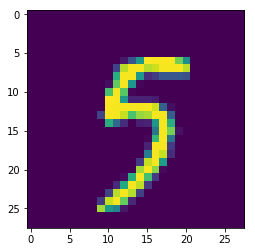

In [28]:
i = 420
plt.imshow(train_input[i, 0, :, :])
print(train_target[i].item())

## 1) LeNet with disjoint trainset and testset

In [7]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

in_channels = train_input.shape[1]
out_channels = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size = 5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 5)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size = 3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size = 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    
LeNet_gen = lambda : Net()


LeNet_gen2 = lambda : nn.Sequential(
        nn.Conv2d(in_channels, 6, kernel_size=(5, 5)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(6, 16, kernel_size=(5,5)),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        View([-1]),

        nn.Linear(256, 120),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Dropout(),

        nn.Linear(84, out_channels),
        nn.Sigmoid()
    )

In [8]:
#debug_layers_dims(LeNet_gen(), train_input.shape)

In [9]:
target_classes = np.array(train_target.tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                       0.00142           0.599         0.00009           0.692
10                      0.00007           0.978         0.00001           0.981
20                      0.00005           0.986         0.00000           0.985
30                      0.00003           0.990         0.00000           0.988
39                      0.00003           0.992         0.00000           0.988
*******************************************************************************


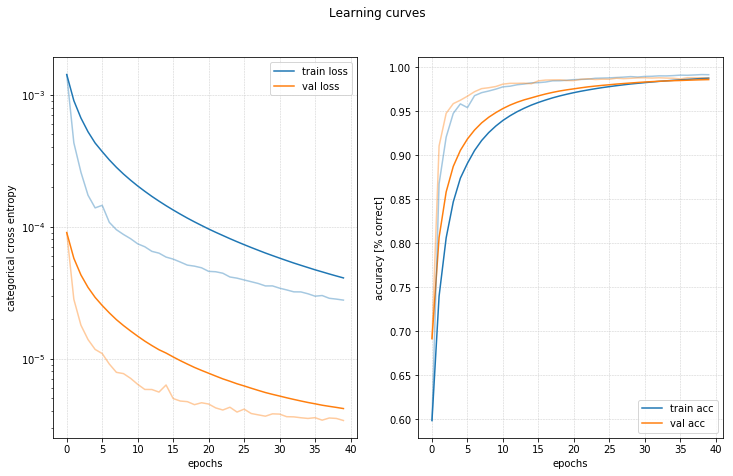

In [10]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

LeNet = LeNet_gen()
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.05

mt = ModelTrainer(LeNet, loss_fun, optim.SGD(LeNet.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, test_dataset, epochs=40, batch_size=1000, verbose=10)
mt.plot_training("Learning curves")

## 2) Testing with a fraction of data from trainset (10%)

In [ ]:
test_input.shape

In [43]:
def generate_biasedset(train_dataset, test_dataset, bias=0.2, plot=False):
    train_input = train_dataset[0]
    train_target = train_dataset[1]
    test_input = test_dataset[0]
    test_target = test_dataset[1]
    
    biased_input = test_input.clone()
    biased_target = test_target.clone()

    N = len(train_input)
    indices_add = np.random.choice(np.arange(0, N), int(bias * N))

    M = len(test_input)
    indices_replace = np.random.choice(np.arange(0, M), int(bias * M))

    for i in range(len(indices_add)):
        biased_input[indices_replace[i]] = train_input[indices_add[i]]
        biased_target[indices_replace[i]] = train_target[indices_add[i]]
        
    if plot:
        plt.subplot(121)
        plt.imshow(biased_input[indices_replace[0]][0])
        plt.subplot(122)
        plt.imshow(test_input[indices_replace[0]][0])

    return (biased_input, biased_target)

def generate_newdataset(train_dataset, test_dataset, split=0.7):
    train_input = train_dataset[0]
    train_target = train_dataset[1]
    test_input = test_dataset[0]
    test_target = test_dataset[1]
    
    N_train = int(0.7* len(train_input))
    N_test = int(0.7 * len(test_input))
    
    g_train_input = torch.cat((train_input[:N_train], test_input[:N_test]), 0)
    g_train_target = torch.cat((torch.ones(N_train), torch.zeros(N_test)), 0)
    g_test_input = torch.cat((train_input[N_train:], test_input[N_test:]), 0)
    g_test_target = torch.cat((torch.ones(len(train_input) - N_train), torch.zeros(len(test_input) - N_test)), 0)
    
    if train_input.is_cuda:
        g_train_target = g_train_target.cuda()
        g_test_target = g_test_target.cuda()
    
    return g_train_input, g_train_target, g_test_input, g_test_target
    
    

def get_snapshots_f(model, layers, layer_names, data):
    with torch.no_grad():
        model.eval()
        
        idxs = torch.randperm(data.shape[0])
        output_d, handle_d = spyOn(layers, layer_names)
        _ = model(data[idxs])
        
        outputs = None
        
        for name in layer_names:
            output = output_d[name].reshape(data.shape[0], -1)
            if outputs is None:
                outputs = output
            else:
                outputs = torch.cat((outputs, output), 0)
            
        handle.remove()
                
        return outputs
            

In [46]:
def generate_dataset_g(model, train_dataset, test_dataset, layers, layer_names, split=0.7):
    new_train_input, new_train_target, new_test_input, new_test_target = generate_newdataset(train_dataset, test_dataset, split)
    
    g_train_input = get_snapshots_f(model, layers, layer_names, new_train_input)
    g_test_input = get_snapshots_f(model, layers, layer_names, new_test_input)
    
    return (g_train_input, new_train_target), (g_test_input, new_test_target)

In [48]:
g_train, g_test = generate_dataset_g(LeNet, train_dataset, test_dataset, [LeNet.conv2], ['conv 2'])

In [51]:
g_train[1]

tensor([1., 1., 1.,  ..., 0., 0., 0.])

In [37]:
snapshots = get_snapshots_f(LeNet, g_train[0])

In [40]:
g_train[1].shape

torch.Size([49000])

In [39]:
snapshots.shape

torch.Size([49000, 1024])

In [114]:
target_classes = np.array(biased_dataset[1].tolist())
unique, counts = np.unique(target_classes, return_counts=True)

print(dict(zip(unique, counts)))
crossEntropyClassesWeigths = Tensor(counts/len(target_classes))

{0: 85, 1: 121, 2: 110, 3: 112, 4: 108, 5: 95, 6: 80, 7: 105, 8: 86, 9: 98}


In [ ]:
crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

LeNet = LeNet_gen()
loss_fun = nn.CrossEntropyLoss(weight=crossEntropyClassesWeigths)
learning_rate = 0.1

mt = ModelTrainer(LeNet, loss_fun, optim.SGD(LeNet.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(train_dataset, biased_dataset, epochs=40, batch_size=100, verbose=10)
mt.plot_training("Learning curves")

In [ ]:
## 3) Hooks definition to get layers activations

In [13]:
activation_output = dict()

In [14]:
def spyOn(model, dict_, name):
    def hook_fun (m, input_, output_): 
        dict_[name] = output_
        #print("captured output at layer : "+str(m)) 
            
    handle = model.register_forward_hook(hook_fun)
    return handle

In [15]:
#Can use the handle to remove the hook, don't execute twice on 
#the same handle, or you won't be able to remove the first
#instance of the hook
handle = spyOn(LeNet.conv2, activation_output, 'convolution 2')

In [16]:
LeNet.eval()
LeNet(train_input[0:3].reshape(-1, 1, 28, 28))

tensor([[-1.9312, -3.5758, -2.0006,  9.7285, -8.2027, 13.8572, -6.2496, -4.0572,
          3.4765,  1.6258],
        [16.1245, -4.6188,  3.4893, -5.6389, -3.9808, -2.4764,  1.5334, -4.0126,
         -1.0302,  0.1764],
        [-6.5326,  0.3822,  2.0937, -1.7134, 13.2932, -2.1166, -6.1563,  5.6843,
         -3.0532,  3.2147]], grad_fn=<ThAddmmBackward>)

In [42]:
torch.cat((torch.tensor(), activation_output['convolution 2'].reshape(3, -1)), 0)

TypeError: tensor() missing 1 required positional arguments: "data"

In [18]:
handle.remove()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(alexnet.parameters(), lr=0.001)

In [ ]:
target.reshape(-1, 1)

In [ ]:
crit_fun = lambda input_, target : (input_, target.reshape(-1, 1))
y_hat_fun = lambda y: y.max(1)

mt = ModelTrainer(alexnet32, criterion, optimizer, y_hat_fun, crit_fun)
hist = mt.fit((train_input, train_target), (test_input, test_target), epochs=500, batch_size=250, verbose=10)
mt.plot_training("Learning curves")